In [1]:
# get pytorch device
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [3]:
import random
import os
import numpy as np
import json
import string
import re
from collections import Counter

import matplotlib.pyplot as plt
import PIL
import cv2
import easyocr
import tqdm
import contractions
import nltk
import shutil
import wordninja
from unidecode import unidecode
from easyimages import EasyImageList,EasyImage
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torchtext.data.utils import ngrams_iterator
from ftlangdetect import detect
from wordcloud import WordCloud
from nltk.corpus import stopwords
from num2words import num2words
from fuzzyset import FuzzySet

random.seed(42)

In [4]:
nltk.download('stopwords') # Downloading the stopwords dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sakshigupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
tokenizer = get_tokenizer("basic_english")

# Data Exploration

### Image Exploration
* Print the count of images
* Print dimension and plot the dimension to identify if any resizing would be required. CNN's require fix input size, so need to explore on the image size.
* Identify if any of the image is corrupted
* Image Color Intensity to identify dark and light images which could come handy later on to tune the model

In [6]:
PROJECT_DIR = os.getcwd()  # get the current working directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data') # Concatenate the working directory with folder name which contains images
DATA_DIR  # Check the final path value

'/home/sakshigupta/Desktop/meme-generation/data'

In [7]:
# Get the path of the data-processed folder (This folder will be used to hold all the processed images and cleaned memes)
processed_data_dir = os.path.join(PROJECT_DIR, 'data-processed')
processed_img_dir = os.path.join(processed_data_dir, 'memes')

In [8]:
# Point to the memes folder from the data directory
image_dir = os.path.join(DATA_DIR, "memes")
image_files = os.listdir(image_dir)  # get the meme images filenames from the path
print(f'The meme image file names : {random.sample(image_files, 5)}')  # print 5 random filenames

# Need to check the images with - 'i-dont-give-a-fuck-sexwithoutpermission.jpg

The meme image file names : ['advice-yoda-gives.jpg', 'el-valor-de-la-verdura-es-verdad.jpg', 'socially-fed-up-penguin.jpg', 'y-u-so.jpg', 'ted-fuck-you-thunder.jpg']


In [9]:
image_list = EasyImageList.from_folder(image_dir)
image_list.html(sample=500, size=50)

In [10]:
print(f'The total image files before removing duplicates : {len(image_files)}')

The total image files before removing duplicates : 2504


In [11]:
for image_file in image_files:
    if '-' in image_file:
        new_filename = image_file.replace('-', '')
        # Before copying the file, check if after removing the dash, the file already exists in processed_img_dir
        if not os.path.exists(os.path.join(processed_img_dir, new_filename)):
            # Copy the file to the new folder
            shutil.copy(os.path.join(image_dir, image_file), os.path.join(processed_img_dir, new_filename))
    else:
        if not os.path.exists(os.path.join(processed_img_dir, image_file)):
            # Copy the file to the new folder
            shutil.copy(os.path.join(image_dir, image_file), os.path.join(processed_img_dir, image_file))

In [12]:
processed_image_files = os.listdir(processed_img_dir)
print(f'The total image files after removing duplicates : {len(processed_image_files)}')

The total image files after removing duplicates : 2488


In [13]:
# Collect memes file attributes
image_count = 0  # variable to keep the count of number of images
image_broken = 0
image_filetypes = {}
image_widths = []
image_heights = []
image_dimensions = {}
image_aspect_ratio = []
image_modes = {}
image_blank = {}

for processed_image_file in processed_image_files:  # Iterate on every meme image
    try:
        image = PIL.Image.open(os.path.join(processed_img_dir, processed_image_file))

        # image count
        image_count += 1

        # Get the count of different extensions for the image
        image_filetypes[image.format] = image_filetypes.get(image.format, 0) + 1

        # retrieve the color mode of each of the image
        image_modes[image.mode] = image_modes.get(image.mode, 0) + 1

        # get the image dimensions
        image_widths.append(image.size[0])
        image_heights.append(image.size[1])

        # get the count of images for each unique dimension
        image_dimensions[image.size] = image_dimensions.get(image.size, 0) + 1

        # determine the aspect ratio of the image
        aspect_ratio = image.size[0] / image.size[1]
        image_aspect_ratio.append(aspect_ratio)

        # determine if image is blank (extrema gives the value of the darkest and lightest pixel)
        # Convert the RGB image to a greyscale and get the extreme pixel values
        extrema = image.convert("L").getextrema()
        # if both the extreme values are same, then the image is just in one color, i.e there is nothing in image (later on we will check what is the caption for the image)
        if extrema[0] == extrema[1]:
            # get the image file and the value of the pixel
            image_blank[processed_image_file] = extrema[0]

        # close the image
        image.close()

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(processed_image_file), e)
        image_broken += 1


# Print all the variables
print("Total memes: {}".format(image_count))
print("Broken memes: {}".format(image_broken))
print("Meme file types: {}".format(image_filetypes))
print("Meme modes: {}".format(image_modes))
print("Meme dimensions: {}".format(image_dimensions))
print("Blank memes: {}".format(image_blank))

Total memes: 2488
Broken memes: 0
Meme file types: {'JPEG': 2488}
Meme modes: {'RGB': 2488}
Meme dimensions: {(250, 250): 2445, (225, 225): 5, (150, 150): 1, (245, 245): 1, (230, 230): 2, (240, 240): 2, (199, 199): 1, (248, 248): 1, (224, 224): 2, (200, 200): 3, (226, 226): 1, (232, 232): 1, (227, 227): 2, (210, 210): 1, (220, 220): 2, (174, 174): 1, (135, 135): 1, (216, 216): 2, (195, 195): 1, (128, 128): 1, (180, 180): 1, (183, 183): 1, (213, 213): 1, (211, 211): 1, (170, 170): 1, (194, 194): 1, (233, 233): 1, (208, 208): 1, (157, 157): 1, (197, 197): 1, (360, 356): 1, (222, 222): 1}
Blank memes: {'blanktemplate.jpg': 255, 'blankblack.jpg': 0}


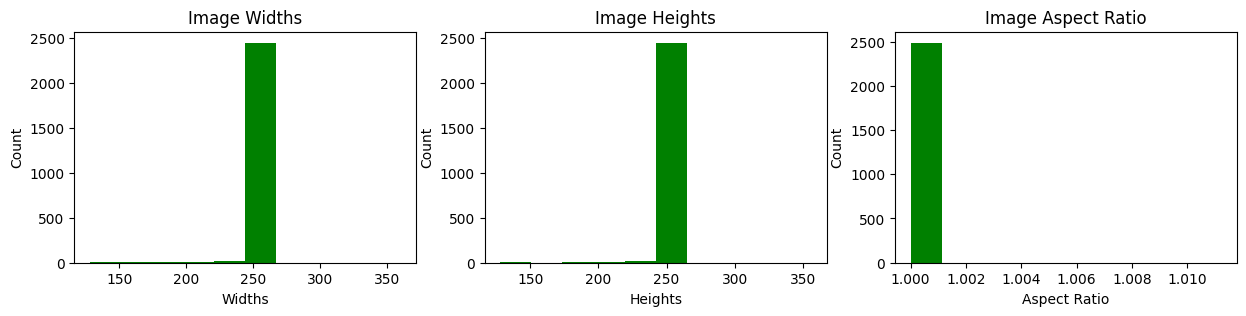

In [14]:
# Get the distribution on the different widths, heights and the aspect ratio of the images
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].hist(image_widths, bins=10,color='green')
ax[0].set_title('Image Widths')
ax[0].set_xlabel('Widths')
ax[0].set_ylabel('Count')

ax[1].hist(image_heights, bins=10,color='green')
ax[1].set_title('Image Heights')
ax[1].set_xlabel('Heights')
ax[1].set_ylabel('Count')

ax[2].hist(image_aspect_ratio, bins=10,color='green')
ax[2].set_title('Image Aspect Ratio')
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Count')

plt.show()

We can see from the plots that the dimensions of most of the images are 250 * 250 and only very few are of dimensions lower than 250. From the meme dimensions variable printed in the previous cell of plot, different dimensions values can be seen and the image count respective to the dimension.
From the aspect ratio it can be seen that we have the square images.
These steps are performed in order to identify the images that would require resizing (images with dimensions other than 250 * 250 ?) - To create the image embeddings we will use **[Inception_V3](https://pytorch.org/hub/pytorch_vision_inception_v3/)** model, and it requires the input size of 299x299x3. So, we will upscale the images. 

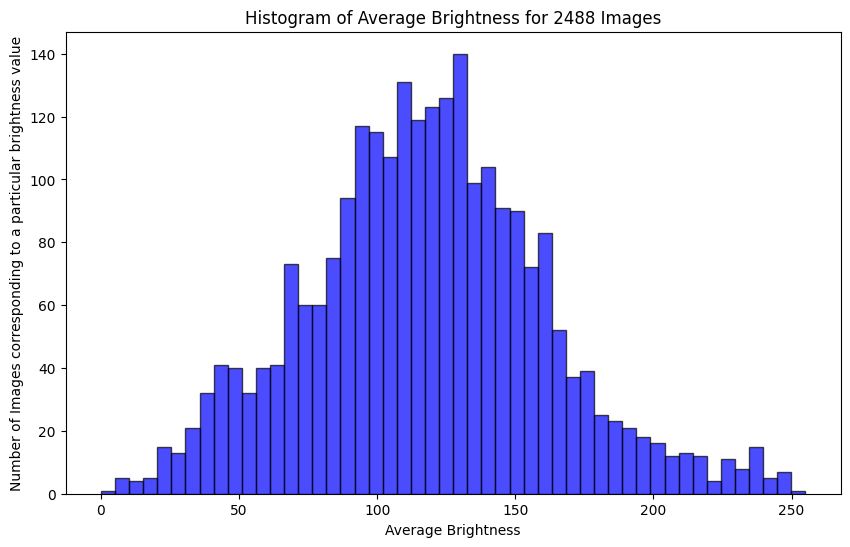

In [15]:
brightness_values = []
darker_image_names = []
lighter_image_names = []

for processed_image_file in processed_image_files:
    image_path = os.path.join(processed_img_dir, processed_image_file)

    # Load the image in greyscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculate average brightness
    avg_brightness = image.mean()

    # Check if average brightness is less than 50, append the image name to the darker_image_names list
    if avg_brightness < 30:
        darker_image_names.append(processed_image_file)
    elif avg_brightness > 240:
        lighter_image_names.append(processed_image_file)

    # For every image, append the average brightness to the list
    brightness_values.append(avg_brightness)

# Plot histogram of brightness values
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='blue', alpha=0.7,edgecolor='black')
plt.title(f'Histogram of Average Brightness for {len(brightness_values)} Images')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images corresponding to a particular brightness value')

# plt.grid(True)
plt.show()

We can see there are some darker images with average brightness on the lower values and some lighter images on the high end values. Brightness can affect feature interpretation of images. May be beneficial to convert the darker image brightness to average image brightness to help in feature detection/interpretation (note to explore)

In [16]:
images_list = []
for dark_img in darker_image_names:
    image_path = os.path.join(processed_img_dir, dark_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()

In [17]:
images_list = []
for light_img in lighter_image_names:
    image_path = os.path.join(processed_img_dir, light_img)
    images_list.append(EasyImage.from_file(image_path))

EasyImageList(images_list).html()

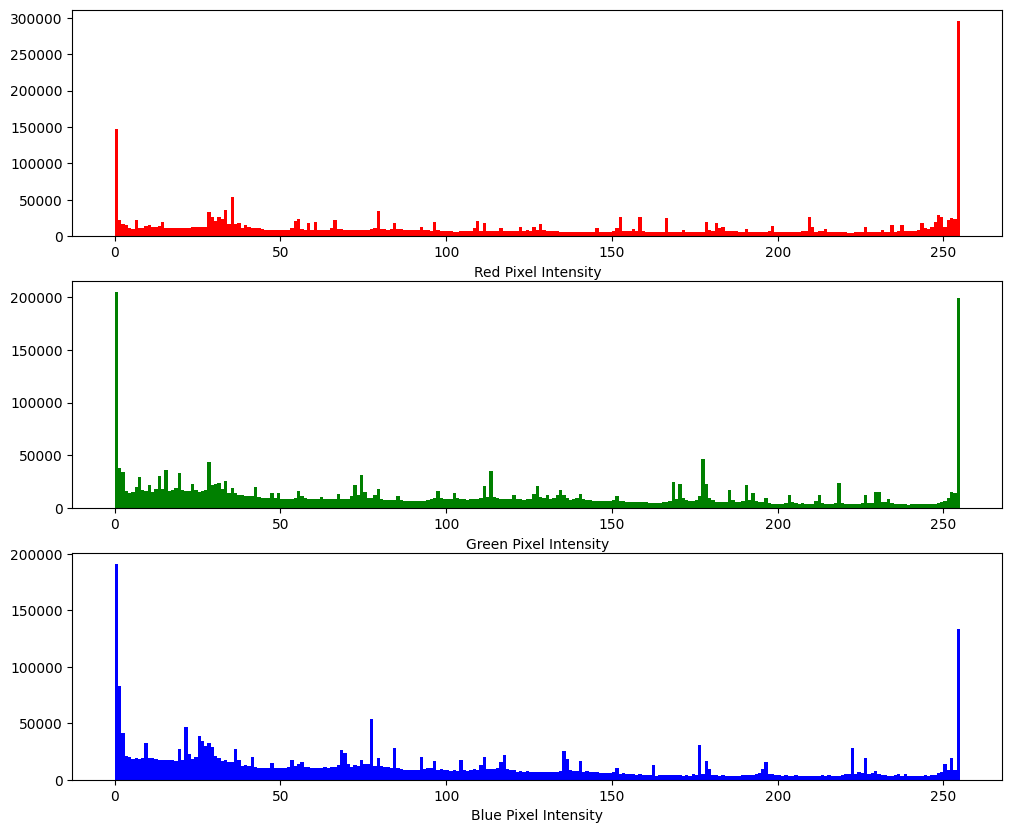

In [18]:
# Image color distribution
colors = {"R": [], "G": [], "B": []}

# For the 50 random images, plot the color distribution
for processed_image_file in random.sample(processed_image_files, 50):
    image = PIL.Image.open(os.path.join(processed_img_dir, processed_image_file))

    image_array = np.array(image)

    colors["R"].extend(image_array[:, :, 0].flatten())
    colors["G"].extend(image_array[:, :, 1].flatten())
    colors["B"].extend(image_array[:, :, 2].flatten())

    image.close()

# Plot color distribution
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].hist(colors["R"], bins=255, color = 'red')
ax[0].set_xlabel("Red Pixel Intensity")

ax[1].hist(colors["G"], bins=255, color = 'green')
ax[1].set_xlabel("Green Pixel Intensity")

ax[2].hist(colors["B"], bins=255, color = 'blue')
ax[2].set_xlabel("Blue Pixel Intensity")

plt.show()

### Identification of the Images with text in it

In [19]:
def extract_text_easyocr(image_path,reader_instance):

    # Use the reader to read text from the image
    results = reader_instance.readtext(image_path)

    # Extract and return the text
    extracted_text = "\n".join([result[1] for result in results])
    if len(extracted_text.strip()) > 0:
        return extracted_text

# dictionary to hold the name of the image and the length of text in it
image_with_text = {}

# Create a reader instance
# The line reader = easyocr.Reader(['en']) is for loading a model into memory. It takes some time but it needs to be run only once.(https://github.com/JaidedAI/EasyOCR/tree/master)
print('Model is starting to get load into the memory')
reader = easyocr.Reader(lang_list=['en'], gpu=True, verbose=True)
print('Model loaded into the memory')

for processed_image_file in tqdm.tqdm(processed_image_files):
    image_path = os.path.join(processed_img_dir, processed_image_file) 

    text_retrieved = extract_text_easyocr(image_path,reader)

    if text_retrieved is not None:
        image_with_text[processed_image_file] = text_retrieved  

Model is starting to get load into the memory
Model loaded into the memory


100%|██████████| 2488/2488 [00:31<00:00, 80.00it/s]


In [20]:
# Print sample of images identified with text

random.sample(list(image_with_text.items()), 5)

[('themoreyouknow.jpg', 'Rekoz%ou_noy'),
 ('overenthusiasticpflagmother.jpg', 'Toay som\nACEME 50\nproudi'),
 ('billoreillyfuckit.jpg', 'SIIJE'),
 ('berkstickets.jpg', 'Gicved'),
 ('southparkbadtimememe.jpg', 'INSTRUCTOR')]

In [21]:
# Get the image name from the dictionary
image_with_text_list = [k for k, v in image_with_text.items()]

images_list = []
for img in image_with_text_list:
    image_path = os.path.join(processed_img_dir, img)
    images_list.append(EasyImage.from_file(image_path,label=[img]))

EasyImageList(images_list).html(by_class=False)

# Note:- The Images have been identified which has text in them. These images are not removed right now, we will train the model
# and if the model output is not good, then we will remove the text from the images or we can remove the imges which just has text in it.

# Captions Text Exploration

In [22]:
# Read the captions file
captions = open(os.path.join(DATA_DIR, "captions.txt"), "r").read()

meme_names = {} # dictionary to store image filename and the meme name
meme_captions = {} # dictionary to store the image filename and the meme captions

previous_captions_img_filename = None

# Collect memes and their associated captions
for line in captions.split("\n"):
    # if the line does not contain a dash, it is a continuation of the previous caption
    if line.find('-') == -1 and previous_captions_img_filename is not None:
        meme_captions[previous_captions_img_filename][-1] += " " + line.strip()
        continue

    # Find the index of the dash which separates the image name and the caption
    split_index = line.index(' - ')
    name, caption = line[0:split_index].strip(), line[split_index + 3:].strip()

    # Ignore the empty meme caption
    if not caption:
        continue

    # generate meme image file name - remove special characters and convert to lowercase.
    # It would be an appropriate way to compare for which images captions are available, as
    # there are lot of discrepancies in the names format in image and captions file.
    captions_img_file_name = re.sub(r"[^a-zA-Z0-9]+", '', name.lower()) + ".jpg"

    # The meme_names is prepared to create the image file name so that it can be compared to which image the captions belong to
    meme_names[captions_img_file_name] = name

    # Add all the captions associated with the particular image
    meme_captions[captions_img_file_name] = meme_captions.get(captions_img_file_name, []) + [caption]

    previous_captions_img_filename = captions_img_file_name  # Add the processed image name

In [23]:
# Find the images for which there is no associated captions
no_captions = set(processed_image_files) - set(meme_captions.keys())
print(f'The total number of images for which no captions were found are :{len(no_captions)}')

# Print a random sample of images for which no captions were found
print('Sample of images with no captions')
random.sample(list(no_captions), 5)

The total number of images for which no captions were found are :32
Sample of images with no captions


['tiffanybitchplease.jpg',
 'allefobommoo.jpg',
 'sbpgti.jpg',
 'funes20aos.jpg',
 'tpicaabuela.jpg']

In [24]:
# Delete these 32 captions from the images folder
for image_file in tqdm.tqdm(no_captions):
    os.remove(os.path.join(processed_img_dir, image_file))

# Update the image files list
processed_image_files = os.listdir(processed_img_dir)
print(f'The number of images left after removing images for which no captions were found : {len(processed_image_files)}')

100%|██████████| 32/32 [00:00<00:00, 14002.89it/s]

The number of images left after removing images for which no captions were found : 2456


In [25]:
# Find out the captions for which there is no image available
no_image = set(meme_captions.keys()) - set(processed_image_files)
print(f'No. of captions for which no image file is available : {len(no_image)}')
no_image

# Note : The .jpg is coming because we have converted the name of the captions to .jpg format to match with image name
# That is how the dataset has been prepared.

No. of captions for which no image file is available : 3


{'duckdynasty.jpg', 'releasethekraken.jpg', 'snsd.jpg'}

We decided to remove the captions for which no images were found because by including these captions, we have no context to what a corresponding image looks like. We feel that only captions with which we can analyze the image should be included for a cleaner and more accurate unique caption generation.

In [26]:
# Remove the captions for which the image was not found
for filename in no_image:
    meme_captions.pop(filename)
    meme_names.pop(filename)

In [27]:
# Remove the image and it's associated captions for the completely dark and light image
meme_captions.pop('blankblack.jpg')  #black image
meme_names.pop('blankblack.jpg')

meme_captions.pop('blanktemplate.jpg') #white image
meme_names.pop('blanktemplate.jpg')

'Blank Template'

In [28]:
# Remove from the image folder also
os.remove(os.path.join(processed_img_dir, 'blankblack.jpg'))
os.remove(os.path.join(processed_img_dir, 'blanktemplate.jpg'))

In [29]:
processed_image_files = os.listdir(processed_img_dir)  # Read again, because some files have been removed
print(f'The number of images left after removing plain black and white images : {len(processed_image_files)}')

The number of images left after removing plain black and white images : 2454


Text Pre-processing

* Remove multiple spaces
* Convert text to lowercase
* Convert non-english to english
* Convert contractions

In [30]:
# An example block
# caption = "Hello, this is some non-ASCII text: Café and Pokémon."
# caption = '¿Qué te gusta hacer?'
caption = 'No hablo español'
ascii_caption = unidecode(caption)

print(ascii_caption)

No hablo espanol


In [31]:
# Example to check if __and / will be removed
re.sub(r'(?<=\w)[-\/_](?=\w)', ' ', 'teenager___posts/tumblr')

'teenager   posts tumblr'

The function **preprocess_captions** is written to perform below steps - 
1. Convert the captions to <u>lowercase</u>.
2.  ***<u>Remove multiple spaces and multiple punctuation marks</u>*** : They will not add any value to the meme generation. Additionally, in the text exploration it was found that some of the captions only have the punctuation marks. Eg - '!!!!!!!!!', '.................'. For the memes we need text, so that our model can have better context.

3. ***<u>Convert Non-ASCII charcters to ASCII characters</u>***: We are generating memes in English language, and in English language there is no unicode characters.<br>
4. ***<u>Removal of URL's</u>***: URL's do not give any funny information about image. So, it will be unnecessary to keep URL's.<br>
5. ***<u>Expanded contractions</u>***: The contractions need to be expanded to remove ambiguity. For example - you're can mean "you are" and "you were". We are going to use the pre-trained embeddings GloVe, and it will be beneficial to expand contractions to ensure that each word aligns well with the pre-trained vectors. Furthermore, when we will train the model and will generate the memes, we can revisit the point.<br>
6. ***<u>Removed forward slash and underscore ocurring between words</u>***: It was done to reduce the vocabulary size.<br>
7. ***<u>Removed hypen only when text is associated with it</u>***: hypen between digits means subtraction, so we do not want to lose that context.
8. ***<u>Converted numbers to it's associated words</u>***: In the Glove, there are very few digits, but there are the corresponding text form of it.
So, converted digits in it's word form to get the embeddings.
9. ***<u>Check for words existence in wordscleaning_dictionary.json</u>***: It is done after looking for the pattern in Glove tokens.


In [34]:
re.sub(r'(?<=\w)[\/_](?=\w)', ' ', 'Hi self-esteem is in/thh_hh')  

'Hi self-esteem is in thh hh'

In [32]:
# Read the file wordscleaning_dictionary.json (This was prepared by comparing the meme words and GloVe words, to make the meme words searchable in GloVe)
with open(os.path.join(PROJECT_DIR, 'data-processed', 'wordscleaning_dictionary.json'), 'r') as fp:
    wordscleaning_dictionary = json.load(fp)

In [37]:
def preprocess_captions(caption):
    """
    Preprocess the captions of the memes
    """
    caption = caption.lower()  # Convert to lowercase

    # Remove multiple spaces 
    caption = re.sub(r"\s+", " ", caption)

    # Replace same punctuation marks occurring multiple times with a single instance
    caption = re.sub(r"([^A-Za-a0-9])\1+", r"\1", caption)
   
    # Change the non-ascii characters to ascii characters
    caption = unidecode(caption)

    # Remove URLs 
    caption = re.sub(r"http\S+", "", caption) 
    
    # Expand contractions
    caption = contractions.fix(caption)

    # Split the words joined with forward slash or _
    caption = re.sub(r'(?<=\w)[\/_](?=\w)', ' ', caption)    
    
    # Do not remove hypen, if before the hypen there is a number and after the hypen there is a number
    pattern1 = re.compile(r'(?<=[^\d])-(?=[^\d])') # This pattern will look for self-esteemed
    caption = pattern1.sub(' ', caption)
  

    pattern2 = re.compile(r'(?<=[^\d])-|-(?=[^\d])') # This pattern will look for self-5 or 5-self
    caption = pattern2.sub(' ', caption)
    
    pattern3 = re.compile(r'(?<=\d)-(?=\d)') # This pattern will look for 5-5
    caption = pattern3.sub(' - ', caption)
 
    # Remove multiple spaces 
    caption = re.sub(r"\s+", " ", caption)

    # Convert the numbers to it's corresponding words (this would be helpful for GloVe embeddings)
    caption = ' '.join([num2words(word) if word.isdigit() else word for word in tokenizer(caption)])

    # Check if the word is present in the wordscleaning_dictionary, if yes, replace it with the value of the key    
    caption = ' '.join([wordscleaning_dictionary[word] if word in wordscleaning_dictionary else word for word in tokenizer(caption)])
 
    return caption

# Check some of the examples
print(preprocess_captions('Sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "Iper-connessionati"'))
print(preprocess_captions('I told him we\'re sending the national un-watering team!'))
print(preprocess_captions('I told-him-we-are - a/team!'))
print(preprocess_captions('remake$$$$$$$$$$$$$$$'))
print(preprocess_captions('i am not that hungry orders 6x6 animal style burger and fries at in n out'))

sono economicamente mesi pegio di noi italiani riescono a permetersi una rete migliore dela nostra , tanto da definirsi iper conesionati
i told him we are sending the national un watering team !
i told him we are a team !
remake$
i am not that hungry orders six by six animal style burger and fries at in n out


In [38]:
print(preprocess_captions("llc ? 501c ? how about an 0u812"))

lc ?  ? how about an oh you ate one too


#### After performing the pre-processing step, it is checked that there are no duplicate captions for each of the image/caption name. If there are any duplicate captions those are removed.
It is also removed so while training the model, repetition and some bias is reduced towards specific terms showing in a specific order. 

In [39]:
# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(preprocess_captions, captions))

    # Remove duplicate captions
    original_length = len(captions)

    # get the count of each caption
    counter = Counter(captions)

    # get the captions which are duplicate
    duplicates = [item for item, count in counter.items() if count > 1]

    # remove the duplicate captions
    meme_captions[filename] = list(set(captions))

    new_length = len(meme_captions[filename])

    # The below code is written so that on GitHub the long output is not generated
    if False and original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))
        # print the duplicate captions
        print("Duplicate captions: {}".format(duplicates))

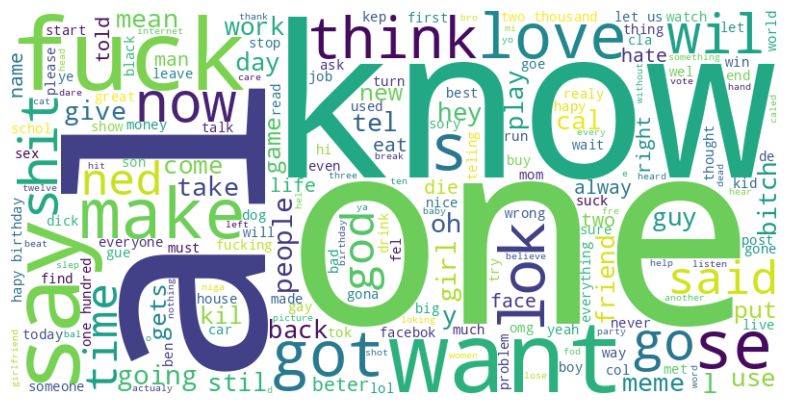

In [40]:
#Using unique captions to capture the most popular words

# Combining all of the captions into one long string
combined_text = " ".join(str(text) if isinstance(text, str) else " ".join(text) for text in meme_captions.values())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text) # Generating wordCloud

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From this Word Cloud we can see the most commonly occuring words within our meme captions. From this word cloud we can see tha a good amount of captions contain some angle of profanity, which will need to be replaced. We will likely replace the profanity with a series of specific characters. This Word Cloud contains Stop Words. We wanted to identify what words come more frequently as for our model, stopwords WILL be necessary in caption generation due to the nature of meme captions. 

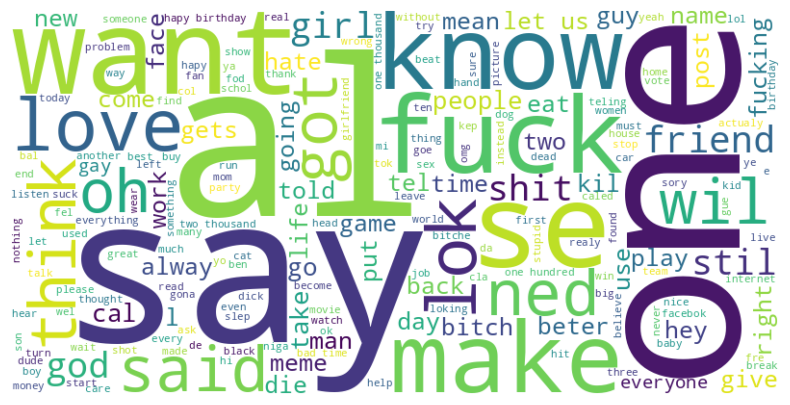

In [41]:
# split it into words
words = combined_text.split()

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the sentence
filtered_sentence = [word for word in words if word.lower() not in stop_words]

# Join the filtered words back into a sentence
filtered_sentence = ' '.join(filtered_sentence)

wordcloud_noStop = WordCloud(width=800, height=400, background_color="white").generate(filtered_sentence) #Generating wordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_noStop, interpolation="bilinear")
plt.axis("off")
plt.show()

The above Word Cloud does not contain stopwords, giving us a look at higher word frequencies in our captions that are not stopwords. This Word Cloud is more for reference. We have decided to not omit stopwords from our training corpus for caption generation. 

In [42]:
# This additional preprocessing is done to remove the numbers which are attached to the text.
def additional_preprocess(caption):

    # Check if the number and text has no space between them. The number can be
    # in front of text or after text or at both sides. Apply the regex to all the 3 cases
    caption = re.sub(r'(\d+)([a-zA-Z]+)(\d+)', r'\1 \2 \3', caption)   

    caption = re.sub(r'(\d+)([a-zA-Z]+)|([a-zA-Z]+)(\d+)', r'\1 \2', caption)
    
    # Convert the numbers into it's word form
    caption = ' '.join([num2words(word) if word.isdigit() else word for word in tokenizer(caption)])

    return caption


# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(additional_preprocess, captions))

    # Remove duplicate captions
    original_length = len(captions)

    # get the count of each caption
    counter = Counter(captions)

    # get the captions which are duplicate
    duplicates = [item for item, count in counter.items() if count > 1]

    # remove the duplicate captions
    meme_captions[filename] = list(set(captions))

    new_length = len(meme_captions[filename])

    # The below False condition is added in code so that on GitHub the long output is not generated
    if False and original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))
        # print the duplicate captions
        print("Duplicate captions: {}".format(duplicates))

Tokenizing all of the captions. We will use this when creating the text embedding.

In [43]:
# Generate vocabulary from the captions
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        # Add all the tokens created by (tokenizer(caption)) to the vocab list (extend adds multiple elements to the list)
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))# Generate vocabulary from the captions

Vocabulary size: 131180


### Identify the occurrence of the least used words in captions. Analyze if those words would be worth keeping so that we can avoid unnecessary vocabulary size.

For count 1 ['nananananananananananananananananananananananananananananana', '#takesyouforevertoread', 'septquinquagintillion', 'quinquinquagintillion', 'quattuorquinquagintillion', 'novemquadragintillion', 'analytics@socialbrothers', 'wubwubwubwawawaawobwobwob', 'neishxjqoaopqkencnwianwkanchwkanxkflwlxjrbwkansndnfkelnznw', 'gahwahfebenlebenargle', 'asijfghiuayewfiaviuaytvjfevk', '#wewantjustinstwiterback', 'jajajajajajajajajajaja', 'hahahahahahahahahahahahahahahahahaha', '#kilalstraightwhitemen', 'fapfapfapfapfapfapfap', 'heheheheheheheheheheh', 'intertouchdownception', 'auhejcofpqpfkcnrjsotjksjfnskclehx', 'oakxjspsnsjznapmapzkqos', 'ntrplntryprplythrnydrgn', 'imageid=5864688&generatortypeid=&panels=&', 'germihematrophicdysplasia', '1234679099765421356890$76', 'rinfgieorgntrhbgvuhiudbrucinudgdngiulnh', 'cudbfrgbrgtrbhgtrbfrbdev', 'agagagsgwsgdasgdfasgfgsfjkdghjkfsjkgaedgfjksdgjhk', 'igrababrushandputonalitlemakeup', 'cockjuglingthunderbolt', 'aaaaaaaawaawawawaaaaaaaaaaaaaaaaswreglalal

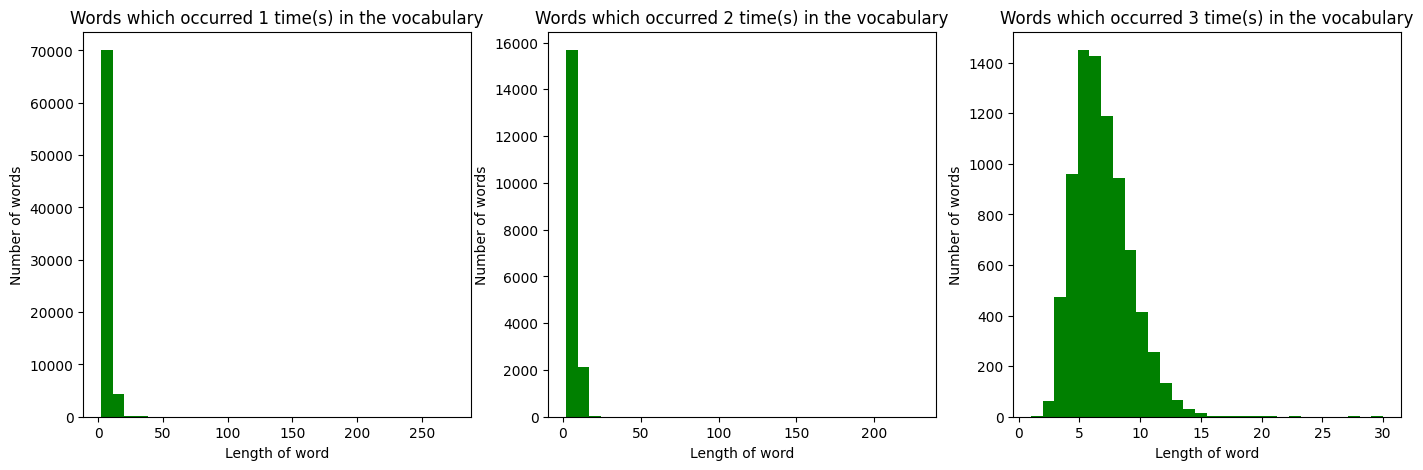

In [44]:
# Count the occurrence of words in vocabulary
wordcount = Counter(vocab)
# Plot the length of words which has the count of 1,2,3

# Create a subplot for each count
fig,ax = plt.subplots(1, 3, figsize=(17, 5))

for i in range(1,4):
    # Get the words which has the count equal to i
    words = [word for word, count in wordcount.items() if count == i]

    # Print the word which is of length > 20
    print(f'For count {i}',[word for word in words if len(word) > 20])   

    # Plot the histogram
    ax[i-1].hist([len(word) for word in words], bins=30,color='green')
    ax[i-1].set_title(f'Words which occurred {i} time(s) in the vocabulary')
    ax[i-1].set_xlabel("Length of word")
    ax[i-1].set_ylabel("Number of words")

# Note:- We can see the presence of words which would not make sense even for meme generation

We have analyzed that the words whose length is greater than 20 are not the good words i.e. they do not have any meaning even for memes. It seems like somebody have made the captions by just inputting random characters. Example - asijfghiuayewfiaviuaytvjfevk, 23579888988588783701132217644322286884. There are also captions which are just the numbers, so we want to remove those too. However, we will keep the text that starts with #tag.

In [45]:
# Get the words where length of the word is greater than 20, but remove the words which start with #
# from consideration of the words with length > 20.
# We have analyzed the words, and there are no words that start with word and have # between them (^'[^#].*#)
least_common_words = [word for word, count in wordcount.items() if len(word) > 20 and word[0] != '#']
least_common_words

['nananananananananananananananananananananananananananananana',
 'septquinquagintillion',
 'quinquinquagintillion',
 'quattuorquinquagintillion',
 'novemquadragintillion',
 'mayoupleasrepethaword',
 'analytics@socialbrothers',
 'wubwubwubwawawaawobwobwob',
 'neishxjqoaopqkencnwianwkanchwkanxkflwlxjrbwkansndnfkelnznw',
 'gahwahfebenlebenargle',
 'ahahahahahahahahahaha',
 'asijfghiuayewfiaviuaytvjfevk',
 'jajajajajajajajajajaja',
 'hahahahahahahahahahahahahahahahahaha',
 'fapfapfapfapfapfapfap',
 'heheheheheheheheheheh',
 'intertouchdownception',
 'auhejcofpqpfkcnrjsotjksjfnskclehx',
 'oakxjspsnsjznapmapzkqos',
 'ntrplntryprplythrnydrgn',
 'imageid=5864688&generatortypeid=&panels=&',
 'germihematrophicdysplasia',
 '1234679099765421356890$76',
 'rinfgieorgntrhbgvuhiudbrucinudgdngiulnh',
 'cudbfrgbrgtrbhgtrbfrbdev',
 'scienceofrelationships',
 'agagagsgwsgdasgdfasgfgsfjkdghjkfsjkgaedgfjksdgjhk',
 'igrababrushandputonalitlemakeup',
 'cockjuglingthunderbolt',
 'aaaaaaaawaawawawaaaaaaaaaaaaa

In [46]:
# Replace the least common words with <unk>

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        captions[i] = " ".join(
            [
                "<unk>" if word in least_common_words else word
                for word in tokenizer(caption)
            ]
        )

In [ ]:
# Remove all captions with just <unk>, less than 3 tokens and just punctuations - to get more clean tokens
# which would be helpful in training the model

def is_valid_caption(caption):
    """
    Check if the caption is valid
    """
    
    tokens = tokenizer(caption)

    if len(tokens) < 3:  # Check if only 2 tokens are present
        return False

    if set(tokens) == {"<unk>"}: # Check if all the tokens are <unk>
        return False

    # Check if the tokens are alphanumeric or alphabets with punctuations (w/o space)
    # This is done to check if the memes are only with punctuation marks
    alphanumeric_tokens = list(filter(lambda x: x not in string.punctuation, tokens))

    # If there are no alphanumeric tokens, then return false, as it means in captions
    # there are only punctuations 
    if set(alphanumeric_tokens) == '':
        return False
    
    return True   
  

for filename, captions in meme_captions.items():
    # Collect the list of captions which were not valid, i.e would be removed
    invalid_captions = list(filter(lambda x: not is_valid_caption(x), captions))

    # Retrieve the valid captions (filter function is applied to each element of the iterable)
    captions = list(filter(is_valid_caption, captions))

    # Code written to avoid long outputs on GitHub
    if False and invalid_captions:
        print("Removed {} captions from {}".format(len(invalid_captions), filename))
        print("Removed captions are: {}".format(invalid_captions))

    meme_captions[filename] = captions

In [48]:
# Check the vocabulary size again
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        # Add all the tokens created by (tokenizer(caption)) to the vocab list (extend adds multiple elements to the list)
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))# Generate vocabulary from the captions

Vocabulary size: 125492


*Function **is_english_text** is written to identify the language of captions. We want all captions to be in English. The langdetect library was taking too much time to identify the language, so we resorted to [fasttext-langdetect library](https://pypi.org/project/fasttext-langdetect/).<br><br>
The fasttext-langdetect library was also not providing accurate results, so we adopted a custom technique, where we tokenize the captions and created <u>n=3 grams</u>. <br><br>
For all the n grams created for the processed caption, language detection was done individually using fasttext-langdetect. After language detection, we placed a condition --> if more than 30% of the n-grams belong to english language, then the processed caption will belong to English language, otherwise the caption will be appended to non_english_captions list.*

In [49]:
def is_english_text(caption):
    """
    Identification of the language of the text
    """

    tokens = tokenizer(caption)

    languages = [detect(text=ngram)["lang"] for ngram in ngrams_iterator(tokens, 3)]

    
    is_english = (
        len([lang for lang in languages if lang == "en"]) / len(languages)
    ) > 0.3

    return is_english

non_english_captions = []

# Idetify the non-english captions
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

100%|██████████| 2454/2454 [00:47<00:00, 51.75it/s]

29820


['suomalainen somali ? lol',
 'bohrsche atomodel falsch untersekreuzer gibt es',
 'todavia no es navida y ya quiero darte tu noche buena wena',
 'no tienen polvora los envios de ronaldinho',
 'kemas eh . sebelum balik !',
 'degage monsieur je suis mesi',
 'me lamo queren . y soy bien ricaa !',
 'sera que soy familia de peter la anguila',
 'igoe agogo woz ere',
 'no se kiera pasar de verga con el admin']

In [50]:
# Checkpoint, save the identified non-english captions
np.save(os.path.join(processed_data_dir, "non_english_captions.npy"), non_english_captions)

#### Update Non-English Captions

We want our captions all to be in English, so that our model can be trained properly in one language and does not provide random results.
We also want to make sure that we are not sending noise to the model, as meme generation itself is funky and humorous.

In [51]:
# Function to update non-english captions in meme_captions variable with identified english translation.
# The english translation is in the file - optimized_translated_captions.json
def update_meme_captions(meme_captions, optimized_translated_captions):   
    
    # Loop through the dictionary to replace the non-english captions with the english captions
    for filename, captions in tqdm.tqdm(meme_captions.items()):  
        # Loop through all the captions for the processed filename      
        for i, caption in enumerate(captions):
            # If the caption is found in the dictionary of optimized_translated_captions
            # then replace the meme_captions variable processed caption with the english caption
            if optimized_translated_captions.get(caption) is not None:
                meme_captions[filename][i] = optimized_translated_captions[caption]                    

In [52]:
TRANSLATED_CAPTIONS_DIR = os.path.join(processed_data_dir, "optimized_translated_captions.json")

# Load the optimized_translated_captions.json file into a Python dictionary
with open(TRANSLATED_CAPTIONS_DIR, 'r') as f:
    optimized_translated_captions = json.load(f)

# Call the function to update non-english captions in meme_captions variable
update_meme_captions(meme_captions, optimized_translated_captions)

  0%|          | 0/2454 [00:00<?, ?it/s]

100%|██████████| 2454/2454 [00:00<00:00, 38079.53it/s]


In [53]:
# Random spot check if the caption was correctly updated. With the help of printed file name, captions.txt was checked
for file,cap in meme_captions.items():
    for i,c in enumerate(cap):
        if c == 'I was the one who gave the prescription to Inter!':
            print(file)

michelemisseri.jpg


After updating the identified non-english captions with english captions, the fasttext-langdetect library was used again to know
if it still identifies text to be non-english. As we can see, it still marks 6712 captions as non-english captions, and when we analyzed
those captions they were actually not non-english. Additionally, we have used Google Translation for Translation and we know it is more robust and accurate.

We can say that the fasttext-langdetect is giving out the 6712 False Negatives for the English Class. It is due to the reason that the fasttext models are trained on data from Wikipedia, Tatoeba and SETimes which have the formal writing of text for 176 languages. In our scenario we have the memes which have very informal writing like use of short forms to represent words Example - "u" or "y" for "you', "wat" for "what", slangs, characters omitted from the correct spelling of the word etc. 

In [54]:
non_english_captions = []
# Translate captions to english
for filename, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

  0%|          | 0/2454 [00:00<?, ?it/s]

100%|██████████| 2454/2454 [00:39<00:00, 61.84it/s]

6371


['annoying ? yes , i am',
 'draco, draco, draco. wedge paws',
 'blowjob no !',
 'no i do not',
 'i think i am drowning a sexy lady',
 'satan ! batman',
 "i am titov i ' l protect you",
 'omg i love kitkats',
 "oh , wok teh hipie ' s cwying",
 'lainey muhlberg !']

In [55]:
# Finally save the preprocessed captions which are all in english language for future use
with open(os.path.join(processed_data_dir, "cleaned_english_captions.json"), "w") as f:
    json.dump(meme_captions, f)

#### Identify the tokens not available in the GloVe vector and for those tokens do the fuzzy matching, so that we do not have random embeddings for the words

In [56]:
# Initialize the variables we will need - GloVe embeddings, FuzzySet
vector_embeddings = GloVe(name="twitter.27B", dim=25)
fz = FuzzySet(vector_embeddings.stoi.keys())

.vector_cache/glove.twitter.27B.zip: 1.52GB [18:53, 1.34MB/s]                               
100%|█████████▉| 1193513/1193514 [00:11<00:00, 103641.78it/s]


In [57]:
# Read if the meme_captions variable is available in the memory
if 'meme_captions' in locals() or 'meme_captions' in globals():
    print('Variable is available in the memory')
else:
    # Read from the file - cleaned captions and all in english language
    with open(os.path.join(processed_data_dir, "cleaned_english_captions.json"), "r") as f:
        meme_captions = json.load(f)

Variable is available in the memory


In [58]:
# Check if there is any image which has no captions available
empty_captions_images = []
for filename, captions in meme_captions.items():
    if len(captions) == 0:
        empty_captions_images.append(filename)
        print(filename)

smorodina.jpg
gusev.jpg
typicalrgaumcxa.jpg
typicalabiturient20131.jpg


After checking in the original data, for the above listed images there were just 2 or 3 captions available. The captions were junk and based on pre-processing were removed.
So, now we will also remove these from the images folder.

In [59]:
# Remove the above listed images with no captions from the data-processed/memes folder
for empty_captions_image in empty_captions_images:
    os.remove(os.path.join(processed_img_dir, empty_captions_image))

# Read again, because some files have been removed
processed_image_files = os.listdir(processed_img_dir) 
print(f'The number of images available to process : {len(processed_image_files)}')

# Also remove the keys from the meme_captions variable
for empty_captions_image in empty_captions_images:
    meme_captions.pop(empty_captions_image)

print(f'The length of meme_captions is : {len(meme_captions.keys())}')

The number of images available to process : 2450
The length of meme_captions is : 2450


In [60]:
# Check if any of the caption length is less than 4 tokens. If yes, we will remove those
# captions. Also, check if after removing those captions, is there any image without captions
# Remove all captions with less than 4 tokens
def remove_small_captions(caption):
    return len(tokenizer(caption)) >= 4

remove_filenames = []

for file in meme_captions.keys():
    # Updating the dictionary with only the captions that have more than 3 tokens
    meme_captions[file] = list(filter(remove_small_captions, meme_captions[file]))
    
    # Check if any image is left with no captions. If yes, add the filename to the list
    if len(meme_captions[file]) == 0:
        remove_filenames.append(file)

In [61]:
[meme_captions.pop(key) for key in remove_filenames]
# Print the number of images left to process and the length of the meme_captions keys. The values should be same
print(f'The length of meme_captions is : {len(meme_captions.keys())}')

[os.remove(os.path.join(processed_img_dir, key)) for key in remove_filenames]
processed_image_files = os.listdir(processed_img_dir) 
print(f'The number of images available to process : {len(processed_image_files)}')

The length of meme_captions is : 2447
The number of images available to process : 2447


In [62]:
# Read the swear words file (This file has been generated based on the words we have in our corpus)
with open(os.path.join(processed_data_dir, "swear_words_mapping.json"), "r") as f:
    swear_words = json.load(f)

In [63]:
# Performing more cleaning my splitting tokens further
def tokens_preproceesing(tokens):
    new_tokens = []
    for token in tokens:
        # If token has # in it, it means that multiple words will be in combined format
        if token.startswith("#"):
            wordninja_split = wordninja.split(token)
            if len(wordninja_split) > 0 and not wordninja_split[0].isnumeric():
                # since it will not have #, so add # to first word of split
                wordninja_split[0] = "#" + wordninja_split[0]
                # adding the split words to the new_tokens list
                new_tokens.extend(wordninja_split)
            elif len(wordninja_split) > 0 :
                new_tokens.extend(wordninja_split)
        else:
            if token in swear_words.keys():
                new_tokens.append(token)
                continue
                
            if re.match(r'\d+\/', token):
                new_tokens.append("")
                continue
            
            if re.match(r'\<\d+', token):
                new_tokens.append("")
                continue

            if re.match(r'\\0\/', token):
                new_tokens.append("")
                continue
            
            if re.match(r'\/0\\', token):
                new_tokens.append("")
                continue           
            

            # add space between punctuation and word/digits
            pattern = f"(?<!\s)([{string.punctuation}])(?!\s)"
            # if re.match(pattern,token):                
            token_changes = re.sub(pattern, r' \1 ', token)
            new_tokens.append(token_changes)
            # continue
            
            # new_tokens.append(token)

    return new_tokens 

for file, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        # Tokenize the caption
        tokens = tokenizer(caption)
        new_tokens_list = tokens_preproceesing(tokens)
        captions[i] = " ".join(list(map(lambda x: x.strip(), new_tokens_list)))

100%|██████████| 2447/2447 [00:15<00:00, 161.17it/s]


In [64]:
# Determine best replacement token
def best_replacement_token(token):
    candidates = [
        token,
        token.lower(),
        token.upper(),
        token.capitalize()
        # re.sub(r"[^a-zA-Z0-9]+", "", token),
    ]

    for candidate in candidates:
        if candidate in vector_embeddings.stoi:
            return candidate, True
    
    # Check if the token is a swear word
    if token in swear_words:
        candidate = swear_words[token]
        if candidate in vector_embeddings.stoi:
            return candidate, True   
    
    
    # Check if token starts with # and do the fuzzymatch with #itself
    if token.startswith("#"):
        candidate = fz.get(token) 
        if candidate:                     
            # Check in candidate if the word is returned with # 
            for i, data in enumerate(candidate):                
                score,text = data
                # Compare the score of the first candidate with the candidate found with #
                if '#' in text: # Want to get the score of the candidate found with #                    
                    if (candidate[0][0] - candidate[i][0] < 0.25): # if score is less than 0.25, then return the candidate with # (as it would be more appropriate)
                        return candidate[i][1], True

    # Check if the token is a number
    if token.isdigit():
        candidate = num2words(token).replace(" ", "-")
        if candidate in vector_embeddings.stoi:
            return candidate, True
        else:
            candidate = num2words(token)
            if candidate in vector_embeddings.stoi:
                return candidate, True

    if candidates[-1].isdigit():
        candidate = num2words(candidates[-1]).replace(" ", "-")
        if candidate in vector_embeddings.stoi:
            return candidate, True
        else:
            candidate = num2words(candidates[-1])
            if candidate in vector_embeddings.stoi:
                return candidate, True

    # Remove the token from caption if it is not found in the vocabulary and is a number
    if token.isdigit() or candidates[-1].isdigit():
        return "", True 
    
    candidate = fz.get(token) 
    if candidate: 
        return candidate[0][1], True

    # Return the original token if no candidates are found
    return token, False


best_replacement_token("#healthy")

('#health', True)

In [65]:
glove_cleaned_captions = {}
not_found_tokens = []

for file, captions in tqdm.tqdm(meme_captions.items()):
    for i, caption in enumerate(captions):
        # Tokenize the caption
        tokens = tokenizer(caption)

        # Check if every token can be found in the GloVe
        for j, token in enumerate(tokens):
            cleaned_token, found = best_replacement_token(token)
            if not found:
                not_found_tokens.append(token)
                tokens[j] = token
            else:
                # tokens[j] = token
                tokens[j] = cleaned_token

        # Update the captions in the cleaned_captions dictionary
        captions[i] = " ".join(tokens)

100%|██████████| 2447/2447 [20:40<00:00,  1.97it/s]


In [66]:
print(f'The number of tokens that were not found in GloVe are : {len(not_found_tokens)}')

The number of tokens that were not found in GloVe are : 3


In [67]:
# Save what tokens were not found in the GloVe
with open(os.path.join(processed_data_dir, "not_found_tokens.txt"), "w") as f:
    for token in not_found_tokens:
        f.write(token + "\n")

In [68]:
for file,captions in meme_captions.items():
    # Check if there is any image for which there is no caption
    if len(captions) == 0:
        print(f'The image name is :{file}')
        os.remove(os.path.join(processed_img_dir, file))
    for caption in captions:
        if len(caption) < 4:        
            print(f'The image for which a caption length is less than 4 is :{file}')    
            #Remove this caption from list
            captions.remove(caption)

The image for which a caption length is less than 4 is :filmschoolferret.jpg


In [69]:
# Finally save the more rigorously preprocessed captions 
with open(os.path.join(processed_data_dir, "cleaned_english_captions_v1.json"), "w") as f:
    json.dump(meme_captions, f)